# Análise de Sentimento em Avaliações de Usuários com Regressão Não Paramétrica

O Projeto demonstra na prática como aplicar regressão não paramétrica no contexto de  um problema  de  negócio  com  o  objetivo  de  prever  sentimento  em  avaliações  de  usuários. Usaremos dados fictícios.

In [2]:
# Imports
import scipy
import statsmodels
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.stats import kstest

## Criando dados fictícios

In [3]:
# Gerar dados de exemplo
np.random.seed(0)
dia = np.arange(1, 101)

In [5]:
# Score de sentimento do cliente adicionando ruído, ajustado para variar entre 0 e 10
sentimento = 5 + 3 * np.sin(dia / 10) + np.random.normal(scale = 1.5, size = dia.size)

In [6]:
# Garante que os valores estejam dentro do intervalo [0, 10]
sentimento = np.clip(sentimento, 0, 10)

In [8]:
# Criar DataFrame
dados = pd.DataFrame({'Dia': dia,
                      'Sentimento': sentimento})

dados.head()

,Dia,Sentimento
0,1,8.124226
1,2,3.574369
2,3,3.980833
3,4,7.622350
4,5,4.678592


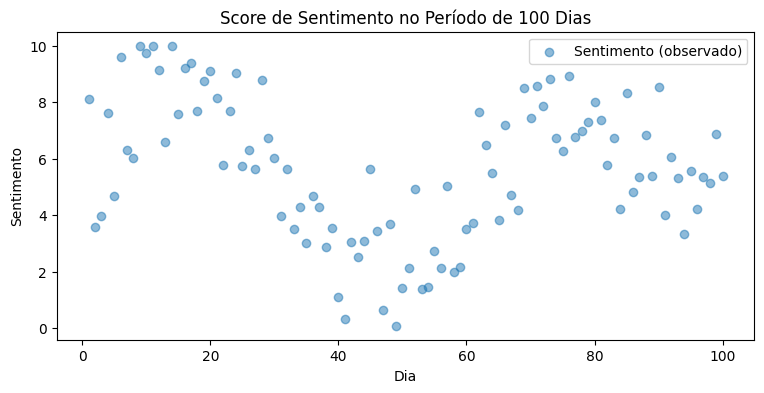

In [27]:
# Plotar os dados
plt.figure(figsize = (9, 4))
plt.scatter(dados['Dia'], 
            dados['Sentimento'], 
            alpha = 0.5, 
            label = 'Sentimento (observado)')
plt.title('Score de Sentimento no Período de 100 Dias')
plt.xlabel('Dia')
plt.ylabel('Sentimento')
plt.legend()
plt.show()

## Regressão LOESS (Locally Estimated Scatterplot Smoothing)

A regressão LOESS (Locally Estimated Scatterplot Smoothing) é uma técnica de modelagem flexível que não depende de muitas das suposições tradicionais associadas a modelos de regressão paramétrica, como linearidade, homogeneidade da variância e distribuição normal dos erros. No entanto, há algumas verificações que você pode fazer para assegurar que o modelo LOESS está fornecendo uma representação adequada dos dados, como veremos a seguir.

https://www.statsmodels.org/devel/generated/statsmodels.nonparametric.smoothers_lowess.lowess.html

Há duas opções:

- Locally Estimated Scatterplot Smoothing (LOESS)
- Locally Weighted Scatterplot Smoothing (LOWESS)

In [17]:
# Aplicar regressão LOESS
frac = 0.1  # Fração dos dados usados na janela local
dados_loess = lowess(dados['Sentimento'], dados['Dia'], frac = frac)

In [18]:
# Converter o resultado para DataFrame
dados_loess_df = pd.DataFrame(data = dados_loess, columns = ['Dia', 'Sentimento_ajustado'])

In [20]:
# Extrair valores ajustados
y_fitted = dados_loess[:, 1]
# Calcular resíduos
residuais = dados['Sentimento'] - y_fitted

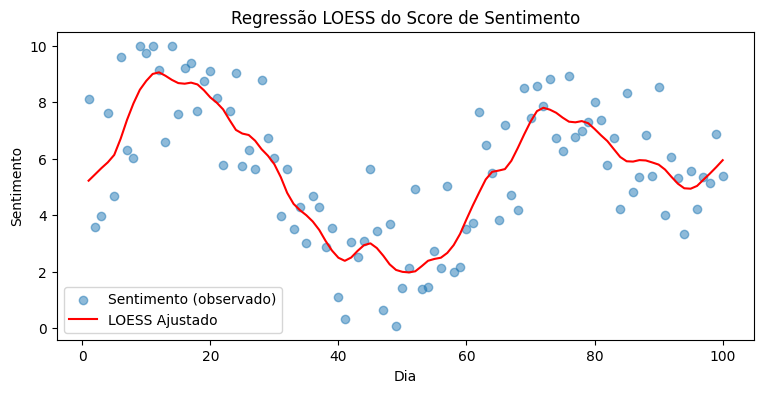

In [26]:
plt.figure(figsize = (9, 4))
plt.scatter(dados['Dia'], 
            dados['Sentimento'], 
            alpha = 0.5,        
            label = 'Sentimento (observado)')
plt.plot(dados_loess_df['Dia'], 
         dados_loess_df['Sentimento_ajustado'], 
         color = 'red', 
         label = 'LOESS Ajustado')
plt.title('Regressão LOESS do Score de Sentimento')
plt.xlabel('Dia')
plt.ylabel('Sentimento')
plt.legend()   
plt.show() 

## Teste não paramétrico de Kolmogorov-Smirnov

O Teste de Kolmogorov-Smirnov (K-S) é tipicamente usado para comparar uma amostra de dados com uma distribuição teórica ou para comparar duas amostras de dados entre si, com o objetivo de testar se elas vêm da mesma distribuição. Embora o teste K-S não seja diretamente usado para validar a aplicação de uma regressão LOESS, ele pode ser útil para verificar as suposições sobre a distribuição dos resíduos de um modelo de regressão. No contexto de uma regressão LOESS, você pode usar o Teste de Kolmogorov-Smirnov para avaliar se os resíduos do modelo seguem uma distribuição normal, o que é uma boa prática na análise de resíduos de regressão, apesar de a regressão LOESS em si não exigir essa suposição.

In [39]:
ks_statistic, p_value = kstest(residuais, 'norm', args = (residuais.mean(), residuais.std()))
print(f'Estatística K-S: {ks_statistic:.4f}')
print(f'Valor p: {p_value:.4f}')

Estatística K-S: 0.0693
Valor p: 0.6963


In [38]:
# Interpretação
if p_value < 0.05:
    print("Os resíduos não seguem uma distribuição normal.")
else:
    print("Não há evidência suficiente para rejeitar a hipótese de que os resíduos seguem uma distribuição normal.")

Não há evidência suficiente para rejeitar a hipótese de que os resíduos seguem uma distribuição normal.


## Uso do modelo


In [41]:
# Vamos prever o sentimento para o dia 105, extrapolando a tendência
dia_novo = 105

In [43]:
# Extraindo a previsão
sentimento_novo = np.interp(dia_novo, dados_loess_df['Dia'], dados_loess_df['Sentimento_ajustado'])

print(f'O score de sentimento estimado para o dia {dia_novo} é {sentimento_novo:.2f}')

O score de sentimento estimado para o dia 105 é 5.94
